# 컨볼루션 신경망(Convolutional Neural Networks, CNN)

- 이번에는 컨볼루션 신경망(CNN)의 개념, 구조, 동작 원리 및 PyTorch와 TensorFlow를 활용한 실습 예제를 통해 CNN의 기본 원리를 이해하고, 실제로 어떻게 구현되는지 학습합니다.

- 특히, 다층 퍼셉트론(MLP)과 CNN의 차이점과 장단점을 비교하여 CNN의 필요성과 효용성을 강조합니다.

## 1. CNN의 기본 개념과 배경

### 1.1 완전 연결 계층(Fully-Connected Layer, nn.Linear())의 문제점

1. 매개변수의 폭발적인 증가

    - 완전 연결 계층은 입력의 모든 뉴런이 출력의 모든 뉴런과 연결되는 구조입니다.
    - 이는 이미지나 영상과 같은 고차원 데이터를 처리할 때, 입력 데이터의 크기가 커지면 매개변수의 수가 급격히 증가하게 만듭니다.
    - 예를 들어, 32x32 크기의 RGB 이미지를 입력으로 받는다면, 입력 뉴런의 수는 3 × 32 × 32 = 3,072개입니다.
    - 출력 뉴런을 1,000개로 설정할 경우, 매개변수의 수는 3,072 × 1,000 = 3,072,000개가 됩니다.


In [ ]:
import torch
import torch.nn as nn

# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self, input_size=3*32*32, hidden_size=1000, output_size=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, 3*32*32)  # Flatten
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 모델 인스턴스 생성
model = MLP()
print(model)

import torchsummary
torchsummary.summary(model, (3, 32, 32))

MLP(
  (fc1): Linear(in_features=3072, out_features=1000, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1000]       3,073,000
              ReLU-2                 [-1, 1000]               0
            Linear-3                   [-1, 10]          10,010
Total params: 3,083,010
Trainable params: 3,083,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 11.76
Estimated Total Size (MB): 11.79
----------------------------------------------------------------


1. 모델 정의

    - nn.Linear(input_size, hidden_size): 입력 크기가 3×32×32=3,072인 완전 연결 계층을 정의합니다.
    - nn.Linear(hidden_size, output_size): 은닉층 크기가 1,000인 완전 연결 계층을 정의합니다.

2. 순전파 과정

    - 입력 데이터를 x.view(-1, 3x32x32)  # Flatten과정을 거쳐 (1차원으로 변환)하여 완전 연결 계층에 입력합니다.

    - 첫 번째 완전 연결 계층을 통과한 후 ReLU 활성화 함수를 적용합니다.
    - 두 번째 완전 연결 계층을 통해 최종 출력값을 얻습니다.

3. 결과 해석

    - 완전 연결 계층은 입력 데이터의 크기가 커질수록 매개변수의 수가 기하급수적으로 증가합니다. 이는 메모리 사용량과 계산량이 크게 늘어나 학습이 어려워지며, 과적합(overfitting)의 위험을 높입니다.

2. 공간적 구조의 손실

    - 완전 연결 계층은 입력 데이터의 공간적 구조나 근접성 정보를 고려하지 않습니다.
    이는 이미지 내에서 인접한 픽셀 간의 연관성을 파악하지 못하게 만듭니다.
    - 결과적으로 이미지의 패턴이나 형태를 효과적으로 학습하기 어렵습니다.

    - 문제점

        - 공간적 정보 손실로 인해 CNN과 같은 구조에서 얻을 수 있는 강력한 특징 추출 능력이 결여됩니다.
        - 이를 해결하기 위해 CNN에서는 지역적 연결(local connectivity)과 가중치 공유(weight sharing)를 도입합니다.

### 1.2 CNN의 등장 배경

- 동물의 시각 피질 구조에서 영감

    - CNN은 동물의 시각 피질(visual cortex) 구조를 모방하여 개발되었습니다.
    - 시각 피질의 신경세포는 시야 내 특정 영역(수용장, receptive field)에만 반응하며, 이러한 특성이 계층적으로 쌓여 복잡한 시각 정보를 처리합니다.

    - 그 결과, 이러한 구조는 이미지의 공간적 패턴과 구조를 효과적으로 학습할 수 있게 합니다.

In [ ]:
# CNN의 기본 구조
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 첫 번째 컨볼루션 레이어
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 두 번째 컨볼루션 레이어
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # 완전 연결 계층
        self.fc = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = x.view(-1, 32 * 8 * 8)              # Flatten
        x = self.fc(x)                           # Fully Connected
        return x

# 모델 인스턴스 생성
model = SimpleCNN()
print(model)

import torchsummary
torchsummary.summary(model, (3, 32, 32))

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Linear-7                   [-1, 10]          20,490
Total params: 25,578
Trainable params: 25,578
Non-trainable params: 0
------------------------

1. 컨볼루션 레이어 정의

    - self.conv1: 첫 번째 컨볼루션 레이어로, 입력 채널 3(RGB)에서 출력 채널 16으로 변환합니다.
    - self.conv2: 두 번째 컨볼루션 레이어로, 입력 채널 16에서 출력 채널 32로 변환합니다.

2. 활성화 및 풀링
    - self.relu: ReLU 활성화 함수를 정의합니다.
    - self.pool: 2x2 맥스 풀링 레이어를 정의합니다.

3. 완전 연결 계층
    - self.fc: 풀링된 특징 맵을 입력받아 10개의 클래스에 대한 출력을 생성합니다.

4. 순전파 과정
    - 첫 번째 컨볼루션 레이어를 통과한 후 ReLU 활성화와 맥스 풀링을 적용합니다.
    - 두 번째 컨볼루션 레이어를 통과한 후 ReLU 활성화와 맥스 풀링을 적용합니다.
    - 최종적으로 풀링된 특징 맵을 Flatten하여 완전 연결 계층에 입력합니다.

5. 결과 해석
    - 이러한 계층적 구조는 입력 이미지에서 점차적으로 복잡한 특징을 추출하여 최종적으로 분류 결과를 도출합니다. 동물의 시각 피질 구조를 모방함으로써, CNN은 이미지의 공간적 패턴과 구조를 효과적으로 학습할 수 있습니다.

- 계층적 특징 추출

    - CNN은 저수준의 간단한 특징부터 고수준의 복잡한 특징까지 계층적으로 추출하여 시각 인식을 수행합니다.

    - 예를 들어, 시각 자극이 1차 시각 피질을 통해 처리된 다음, 2차 시각 피질을 경유하여, 3차 시각 피질 등 여러 영역을 통과하여 계층적인 정보 처리를 진행합니다.

    ```
    시각 자극 → 1차 시각 피질(V1) → 2차 시각 피질(V2) → 고차 시각 피질
    
    시각 자극     →     단순한 특징     →     중간 수준 특징    →    복잡한 특징
    Object    →    (엣지, 방향)    →     (모양, 텍스처)    →    (물체, 얼굴)
    ```

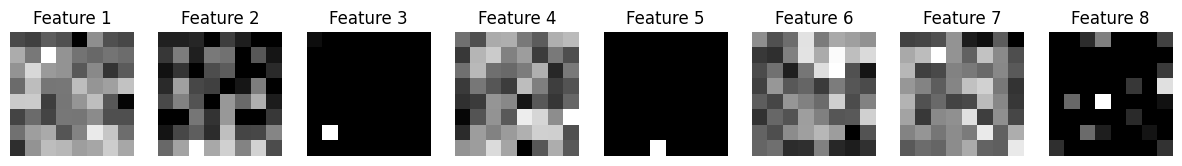

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 간단한 CNN 모델 정의
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  # 저수준 특징 추출
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # 중간 수준 특징 추출
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # 첫 번째 특징 맵
        x = self.pool(self.relu(self.conv2(x)))  # 두 번째 특징 맵
        return x

# 모델 인스턴스 생성
model = FeatureExtractorCNN()

# 가상의 이미지 데이터 생성 (배치 크기 1, 채널 3, 32x32)
input_image = torch.randn(1, 3, 32, 32)

# 특징 추출
features = model(input_image)

# 특징 맵 시각화
def visualize_features(features, num_features=8):
    plt.figure(figsize=(15, 5))
    for i in range(min(num_features, features.shape[1])):
        plt.subplot(1, num_features, i+1)
        plt.imshow(features[0, i].detach().numpy(), cmap='gray')
        plt.title(f'Feature {i+1}')
        plt.axis('off')
    plt.show()

visualize_features(features, num_features=8)

1. 모델 정의

    - self.conv1: 첫 번째 컨볼루션 레이어로, 입력 채널 3에서 출력 채널 16으로 변환하여 저수준 특징(선, 가장자리 등)을 추출합니다.
    - self.conv2: 두 번째 컨볼루션 레이어로, 입력 채널 16에서 출력 채널 32으로 변환하여 중간 수준 특징을 추출합니다.

2. 순전파 과정
    - 첫 번째 컨볼루션 레이어를 통과한 후 ReLU 활성화와 맥스 풀링을 적용합니다.
    - 두 번째 컨볼루션 레이어를 통과한 후 ReLU 활성화와 맥스 풀링을 적용하여 최종 특징 맵을 얻습니다.

3. 특징 맵 시각화
    - visualize_features 함수는 추출된 특징 맵 중 일부를 선택하여 그레이스케일 이미지로 시각화합니다.
    - 이를 통해 각 계층에서 추출된 특징을 직관적으로 이해할 수 있습니다.

4. 결과 해석

    - 시각화된 특징 맵을 통해 각 컨볼루션 레이어가 입력 이미지에서 어떤 특징을 추출하는지 확인할 수 있습니다. 저수준의 컨볼루션 레이어는 간단한 선과 가장자리를 감지하고, 중간 수준의 레이어는 이러한 선들이 결합된 형태를 인식합니다.

### 1.3 CNN의 구조

- 동물의 계층적 특징 추출과 시각 인식 체계를 참조하여 만들어진 모델

    - 전반부(특징 추출기)

        - 컨볼루션 레이어(Convolutional Layer)
            - 입력 데이터에서 지역적 특징을 추출합니다.
        - 풀링 레이어(Pooling Layer)
            - Feature map의 크기를 줄이고, 중요한 특징을 강조합니다.
        - 이를 통해서 입력 데이터에서 유용한 특징을 추출하여 후반부(분류기)로 전달합니다.

    - 후반부(분류기)
    
        - 완전 연결 계층(Fully-Connected Layer)
        
             - 추출된 특징을 기반으로 최종 분류를 수행합니다.

        - 특징 추출기에서 추출된 정보를 바탕으로 최종적인 분류 결과를 도출합니다.

### 1.4 CNN의 장점

CNN은 다층 퍼셉트론(MLP)에 비해 여러 가지 장점을 가지고 있어 이미지 및 영상 처리에서 널리 사용됩니다.

- 적은 매개변수로도 복잡한 모델 구축 가능

    - 공간적 구조를 활용하여 매개변수의 수를 크게 줄일 수 있습니다.

    ```
    # 필터 공유 예시
conv1 = nn.Conv2d(3, 16, 3, padding=1)
conv2 = nn.Conv2d(16, 32, 3, padding=1)

print(conv1.weight.shape)  # torch.Size([16, 3, 3, 3])
print(conv2.weight.shape)  # torch.Size([32, 16, 3, 3])

    ```
    - 그 결과, 동일한 크기의 필터를 여러 위치에서 재사용함으로써 매개변수를 공유하며, MLP 보다 매개변수의 수가 절약할 수 있습니다.
    - 이는 메모리 사용량을 줄이고 학습 효율성을 높입니다.

- 공간적 정보 보존

    - 컨볼루션 연산을 통해 이미지의 공간적 패턴과 구조를 효과적으로 학습할 수 있습니다.
    - 특징 맵(feature map)은 입력 이미지의 중요한 정보를 유지하면서 크기를 줄입니다.

- 다양한 응용 분야

    - 이미지 분류, 객체 탐지, 세그멘테이션, 자연어 처리 등 다양한 분야에서 높은 성능을 보입니다.

- 지역적 특징 학습

    - 필터를 통해 입력 데이터의 작은 영역(local region)에서 특징을 학습하므로, 전체 이미지의 복잡성을 줄이고 효율적으로 학습할 수 있습니다.


  <img src="https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png">

## 2. 컨볼루션 연산(Convolution Operation)

그렇다면, 이번에는 CNN의 핵심 연산인 컨볼루션 연산에 대해 자세히 살펴보겠습니다.

### 2.1 필터(Filter) 또는 커널(Kernel)

- 역할

    - 입력 데이터에 대한 특징을 추출하기 위한 작은 행렬입니다.
    - 이미지 처리에서 사용하는 '이미지 필터'와 유사한 개념입니다.
    - 예를 들어, 엣지 검출, 블러링, 샤프닝 등의 다양한 필터가 있습니다.


In [ ]:
import torch

# 3x3 필터 예시: 엣지 검출
edge_detect_filter = torch.tensor([
    [ -1, -1, -1],
    [ -1,  8, -1],
    [ -1, -1, -1]
], dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 3, 3)

print(edge_detect_filter)

tensor([[[[-1., -1., -1.],
          [-1.,  8., -1.],
          [-1., -1., -1.]]]])


    1. 필터 정의
        - edge_detect_filter: 3x3 엣지 검출 필터를 정의합니다.
        - unsqueeze(0).unsqueeze(0): 필터의 차원을 (out_channels, in_channels, height, width)로 맞추기 위해 차원을 추가합니다.

    2. 출력 확인
        - 필터의 내용을 출력하여 정의된 대로 엣지를 검출할 수 있는지를 확인합니다.

- 크기

    - 일반적으로 홀수 크기를 사용합니다. 예를 들어, 3x3, 5x5, 7x7 등이 있습니다.
        - 홀수 크기를 사용하면 중앙 픽셀이 필터의 기준점이 되어 대칭적인 패딩을 적용할 수 있습니다.
        - 짝수 크기의 필터는 패딩 시 비대칭(왼쪽, 오른쪽을 다르게 주어야 함)이 발생하여 복잡성을 증가시킵니다.

In [ ]:
# 홀수 크기의 필터 예시
filter_size = 3
padding = (filter_size - 1) // 2
print(f"Filter Size: {filter_size}x{filter_size}, Padding: {padding}")

Filter Size: 3x3, Padding: 1


    - 필터 크기가 3x3일 경우, 패딩 크기는 1이 됩니다. 이는 입력 이미지의 가장자리에 패딩을 추가하여 출력 크기를 유지하기 위함입니다.


- 학습 파라미터

    - 필터의 크기는 입력 데이터의 크기와 무관하게 일정하므로, 매개변수의 수를 효과적으로 줄일 수 있습니다.

    - 3x3 필터를 사용하는 경우, RGB 이미지(3채널)에서는 필터당 3 × 3 × 3 = 27개의 가중치가 필요합니다.
    - 그래서 만약에 16개의 필터를 사용한다면, 총 16 × 27 = 432개의 가중치가 필요합니다.
    - 반면에 여러분들이 어제 해보셔서 아시곘지만, 단순한 linear 한 layer로는 한계가 존재합니다.

In [ ]:
# RGB 이미지에 대한 3x3 필터의 학습 파라미터 수 계산
in_channels = 3
filter_size = 3
out_channels = 16

# 각 필터의 파라미터 수
params_per_filter = in_channels * filter_size * filter_size
total_params = out_channels * params_per_filter

print(f"Each filter parameters: {params_per_filter}")
print(f"Total parameters for {out_channels} filters: {total_params}")

Each filter parameters: 27
Total parameters for 16 filters: 432


    1. 파라미터 수 계산
        - in_channels * filter_size * filter_size
            - 하나의 필터당 파라미터 수.
        - out_channels * params_per_filter
            - 전체 필터의 파라미터 수.
    2. 출력 확인
        - 각 필터와 전체 필터의 파라미터 수를 출력하여 매개변수의 수를 이해합니다.
    3. 결과 해석
        - RGB 이미지에 대해 3x3 필터 16개를 사용하는 경우, 총 파라미터 수는 16 × 3 × 3 × 3 = 432개가 됩니다.
        - 이는 완전 연결 계층에서 발생하는 매개변수 폭발 문제를 효과적으로 해결할 수 있음을 보여줍니다.

### 2.2 컨볼루션 연산 과정

1. 슬라이딩

    - 필터를 입력 데이터 위에서 일정 간격(스트라이드)으로 이동시키며 연산을 수행합니다.

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 간단한 슬라이딩 예시
input_image = torch.randn(1, 1, 5, 5)  # 배치 크기 1, 채널 1, 5x5 이미지
filter = torch.tensor([[[[-1, -1, -1],
                         [-1,  8, -1],
                         [-1, -1, -1]]]], dtype=torch.float32)  # 3x3 엣지 검출 필터

# 컨볼루션 연산 수행 (스트라이드=1, 패딩=0)
output = F.conv2d(input_image, filter, stride=1, padding=0)

print("Input Image:\n", input_image)
print("Filter:\n", filter)
print("Output Feature Map:\n", output)

Input Image:
 tensor([[[[-0.1901, -0.4566, -2.3357, -0.6238, -1.2028],
          [ 0.1246,  0.1138,  1.4295, -0.7195,  0.2872],
          [-1.0823,  0.6841,  1.1400,  1.6962,  1.0613],
          [ 0.2573, -0.3714, -0.3859, -0.4372,  0.9239],
          [ 0.1378,  0.2803, -1.8210, -0.8125, -0.0693]]]])
Filter:
 tensor([[[[-1., -1., -1.],
          [-1.,  8., -1.],
          [-1., -1., -1.]]]])
Output Feature Map:
 tensor([[[[ 1.5971, 11.9372, -7.2081],
          [ 4.2474,  7.1105, 10.2704],
          [-2.1813, -3.4459, -5.2307]]]])


    1. 입력 이미지 생성
        - torch.randn(1, 1, 5, 5): 배치 크기 1, 채널 1, 5x5 크기의 랜덤 이미지를 생성합니다.

    2. 필터 정의
        - 엣지 검출을 위한 3x3 필터를 정의합니다.

    3. 컨볼루션 연산 수행
        - F.conv2d: 입력 이미지와 필터를 사용하여 컨볼루션 연산을 수행합니다.
        - stride=1: 필터를 한 픽셀씩 이동시킵니다.
        - padding=0: 패딩을 사용하지 않습니다.

    4. 출력 확인
        - 입력 이미지, 필터, 그리고 출력 특징 맵을 출력하여 연산 과정을 확인합니다.

    5. 결과 해석
        - 컨볼루션 연산을 통해 필터가 입력 이미지의 각 위치에 적용되어 엣지 특징을 강조한 출력 특징 맵을 생성합니다. 스트라이드가 1이므로 출력 크기는 입력보다 작아집니다.

2. 연산

    - 필터와 입력 데이터의 해당 위치의 원소들 간에 요소별 곱셈을 수행한 후, 그 합을 구합니다.


    위의 슬라이딩 예제에서 이미 F.conv2d를 통해 연산이 수행되었습니다. 여기서는 직접 요소별 곱셈과 합을 계산해보겠습니다.

In [ ]:
import torch

# 입력 데이터 및 필터 정의
input_patch = torch.tensor([
    [1.0, 2.0, 3.0],
    [4.0, 5.0, 6.0],
    [7.0, 8.0, 9.0]
])

filter = torch.tensor([
    [-1.0, -1.0, -1.0],
    [-1.0,  8.0, -1.0],
    [-1.0, -1.0, -1.0]
])

# 요소별 곱셈 및 합 계산
result = (input_patch * filter).sum()
print("Result of convolution operation:", result.item())

Result of convolution operation: 0.0


    1. 입력 패치 및 필터 정의
        - input_patch: 3x3 크기의 입력 패치.
        - filter: 3x3 엣지 검출 필터.

    2. 연산 수행
        - 입력 패치와 필터의 요소별 곱셈을 수행한 후, 그 합을 계산합니다.

    3. 결과 확인
        - 연산 결과를 출력하여 필터 적용 후의 값을 확인합니다.

    4. 결과 해석

        - 위의 예제에서 필터를 입력 패치에 적용하면, 중앙 픽셀의 영향이 크게 반영된 결과가 나옵니다. 이는 필터가 엣지와 같은 중요한 특징을 강조하는 역할을 하기 때문입니다.




3. 출력

    - 연산 결과는 특징 맵(feature map)으로 저장됩니다.
    - 그리고, 각 필터는 하나의 특징 맵을 생성합니다.

    앞서의 슬라이딩 예제에서 생성된 출력 특징 맵을 시각화해보겠습니다.

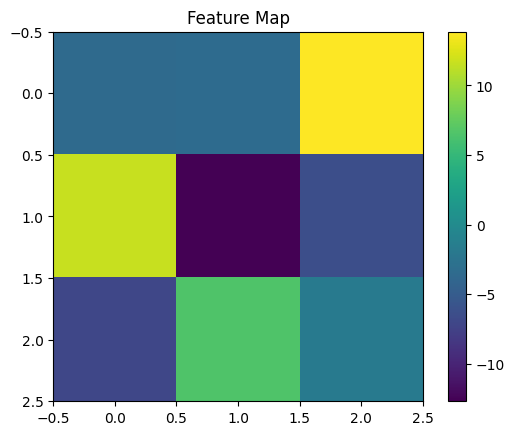

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 입력 이미지 및 필터 정의
input_image = torch.randn(1, 1, 5, 5)
filter = torch.tensor([[[[-1, -1, -1],
                         [-1,  8, -1],
                         [-1, -1, -1]]]], dtype=torch.float32)

# 컨볼루션 연산 수행
output = F.conv2d(input_image, filter, stride=1, padding=0)

# 특징 맵 시각화
plt.imshow(output[0, 0].detach().numpy(), cmap='viridis')
plt.title('Feature Map')
plt.colorbar()
plt.show()

    1. 컨볼루션 연산 수행
        - 입력 이미지와 필터를 사용하여 컨볼루션 연산을 수행하고, 출력 특징 맵을 생성합니다.

    2. 특징 맵 시각화
        - matplotlib을 사용하여 출력 특징 맵을 시각화합니다.
    cmap='viridis': 색상 맵을 설정하여 특징 맵의 값을 시각적으로 표현합니다.

    3. 결과 확인
        - 생성된 특징 맵을 통해 필터가 입력 이미지의 어떤 부분에서 강한 특징을 감지했는지 확인합니다.

    4. 결과 해석
        - 특징 맵은 입력 이미지의 엣지와 같은 중요한 패턴을 강조하여 시각적으로 표현됩니다. 이는 CNN이 입력 데이터에서 유용한 특징을 효과적으로 추출할 수 있음을 보여줍니다.

4. 예시

    - 3x3 필터를 5x5 입력 이미지에 적용하면, (5 - 3 + 1) × (5 - 3 + 1) = 3 × 3 = 9개의 값을 갖는 특징 맵이 생성됩니다.

###  연산 시각화

  <img src="https://www.researchgate.net/profile/Ihab_S_Mohamed/publication/324165524/figure/fig3/AS:611103423860736@1522709818959/An-example-of-convolution-operation-in-2D-2.png" width="500">

### 2.3 출력 크기 계산

패딩과 스트라이드가 없을 경우, 출력 크기는 다음과 같이 계산됩니다.

  $\quad (n-f+1) \times (n-f+1)$

  - $n$: 입력 데이터의 크기  
  - $f$: 필터(커널)의 크기

- 예시

    - 입력 데이터 크기($n$)는 5, 필터의 크기($k$)는 3이므로 출력 데이터의 크기는
    
    $(5 - 3 + 1) = 3$

    <img src="https://miro.medium.com/max/1400/1*Fw-ehcNBR9byHtho-Rxbtw.gif" width="400">

In [ ]:
import torch
import torch.nn.functional as F

# 입력 이미지 및 필터 정의
input_image = torch.randn(1, 1, 5, 5)
filter = torch.tensor([[[[-1, -1, -1],
                         [-1,  8, -1],
                         [-1, -1, -1]]]], dtype=torch.float32)

# 스트라이드=1, 패딩=0으로 컨볼루션 연산 수행
output = F.conv2d(input_image, filter, stride=1, padding=0)

print("Input Shape:", input_image.shape)    # torch.Size([1, 1, 5, 5])
print("Filter Shape:", filter.shape)        # torch.Size([1, 1, 3, 3])
print("Output Shape:", output.shape)        # torch.Size([1, 1, 3, 3])

Input Shape: torch.Size([1, 1, 5, 5])
Filter Shape: torch.Size([1, 1, 3, 3])
Output Shape: torch.Size([1, 1, 3, 3])


    1. 입력 이미지 및 필터 정의
        - 5x5 크기의 입력 이미지와 3x3 필터를 정의합니다.

    2. 컨볼루션 연산 수행
        - 스트라이드 1과 패딩 0을 사용하여 컨볼루션 연산을 수행합니다.

    3. 출력 크기 확인
        - 계산된 공식을 통해 출력 크기가 3x3임을 확인합니다.

    4. 결과 해석

        출력 특징 맵의 크기는 입력 크기, 필터 크기, 패딩, 스트라이드에 따라 결정됩니다. 이 예시에서는 패딩과 스트라이드를 사용하지 않았기 때문에 출력 크기는 입력보다 작아졌습니다. 이는 필터가 입력 이미지의 특정 영역에만 적용되었기 때문입니다.

    > 주의

    - 출력 크기는 정수가 되어야 하며, 그렇지 않을 경우 패딩 또는 스트라이드 값을 조정해야 합니다.
    - 예를 들어, 입력 크기와 필터 크기, 패딩, 스트라이드가 적절히 설정되어야 합니다.

주의 사항으로는, 출력 크기는 정수가 되어야 하며, 그렇지 않을 경우 패딩 또는 스트라이드 값을 조정해야 합니다.

예를 들어, 입력 크기와 필터 크기, 패딩, 스트라이드가 적절히 설정되어야 합니다.

In [ ]:
# 필요한 라이브러리 Import
import numpy as np
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

<ipython-input-11-cef0916ae02e>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


- load_sample_image: 사이킷런에서 제공하는 예제 이미지를 로드합니다.

(427, 640, 3)
float64


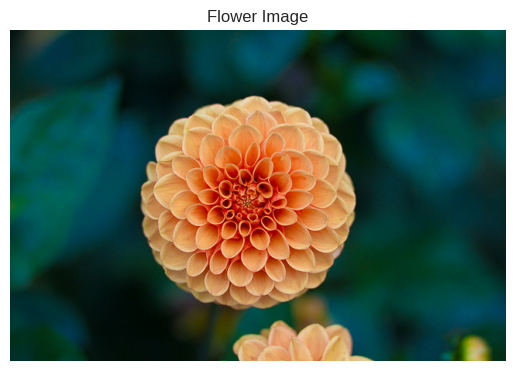

In [ ]:
# 이미지 로드 및 정규화

# 꽃 이미지 로드
flower = load_sample_image('flower.jpg') / 255   # uint -> float -> normalization -> 픽셀 값 범위를 [0, 1]로 정규화
print(flower.shape)  # (427, 640, 3)
print(flower.dtype)  # float64

# 정규화된 꽃 이미지를 시각화
plt.imshow(flower)
plt.title('Flower Image')
plt.axis('off')
plt.show()

- / 255.0: 이미지를 정규화하여 픽셀 값이 [0, 1] 범위가 되도록 합니다.

(427, 640, 3)
float64


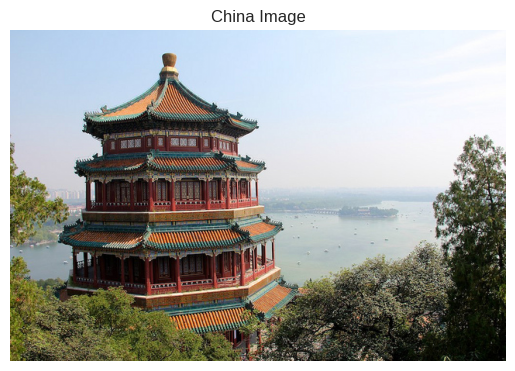

In [ ]:
# 이미지 로드 및 정규화

# 중국 이미지 로드
china = load_sample_image('china.jpg') / 255

print(china.shape)  # (427, 640, 3)
print(china.dtype)  # float64

# 정규화된 중국 이미지를 시각화
plt.imshow(china)
plt.title('China Image')
plt.axis('off')
plt.show()

In [ ]:
# PyTorch 라이브러리 import
import torch

In [ ]:
# PyTorch 텐서로 변환 및 배치 생성
images = torch.stack([torch.from_numpy(china), torch.from_numpy(flower)])  # (batch_size, height, width, channels)
images = images.permute(0, 3, 1, 2)  # (batch_size, channels, height, width)
images = images.to(torch.float32)  # 데이터 타입을 float32로 변환
batch_size, channels, height, width = images.shape

print("Images shape:", images.shape)  # torch.Size([2, 3, 427, 640])

Images shape: torch.Size([2, 3, 427, 640])


1. 텐서 변환 및 배치 생성
    - torch.from_numpy(china): NumPy 배열을 PyTorch 텐서로 변환합니다.
    - torch.stack([...]): 두 이미지를 배치 차원에서 쌓아 하나의 텐서로 만듦. 결과 텐서의 형태는 (batch_size, height, width, channels)입니다.

2. 차원 순서 변경

    - images.permute(0, 3, 1, 2): 텐서의 차원 순서를 (batch_size, channels, height, width)로 변경하여 PyTorch의 컨볼루션 연산에 적합하게 만듭니다.

3. 데이터 타입 변환

    - images.to(torch.float32): 데이터 타입을 float32로 변환하여 연산에 사용합니다.

4. 배치 정보 출력:

    - images.shape: 텐서의 형태를 출력하여 배치 크기, 채널 수, 이미지 크기를 확인합니다.

In [ ]:
# 필터 정의: 수직선과 수평선을 감지하는 필터 생성
filters = torch.zeros(2, 3, 7, 7, dtype=torch.float32)  # (out_channels, in_channels, kernel_height, kernel_width)

# 수직선 감지 필터 설정
filters[0, :, :, 3] = 1  # 중간 열을 1로 설정

# 수평선 감지 필터 설정
filters[1, :, 3, :] = 1  # 중간 행을 1로 설정

print("Filters shape:", filters.shape)  # torch.Size([2, 3, 7, 7])

Filters shape: torch.Size([2, 3, 7, 7])


1. 필터 초기화

    - torch.zeros(2, channels, 7, 7, dtype=torch.float32): 2개의 7x7 필터를 생성. 각 필터는 3채널(RGB) 입력을 받습니다.

2. 수직선 및 수평선 감지 필터 설정

    - filters[:, :, :, 3] = 1: 모든 채널에 대해 필터의 중간 열을 1로 설정하여 수직선을 감지.
    - filters[:, :, 3, :] = 1: 모든 채널에 대해 필터의 중간 행을 1로 설정하여 수평선을 감지.

3. 필터 형태 확인
    - filters.shape: 필터의 형태를 출력하여 (out_channels, in_channels, kernel_height, kernel_width)를 확인.

In [ ]:
# 컨볼루션 연산 수행
import torch.nn as nn

# PyTorch의 Conv2d 레이어 정의 및 필터 적용
conv = nn.Conv2d(in_channels=3, out_channels=2, kernel_size=7, bias=False)
conv.weight.data = filters  # 필터를 컨볼루션 레이어의 가중치로 설정

# 컨볼루션 연산 수행
output = conv(images)  # (batch_size, out_channels, output_height, output_width)

print("Output shape:", output.shape)  # 예: torch.Size([2, 2, 421, 634])

Output shape: torch.Size([2, 2, 421, 634])


1. 컨볼루션 레이어 정의

    - nn.Conv2d(in_channels=channels, out_channels=2, kernel_size=7, bias=False): 3채널 입력을 받아 2개의 7x7 필터로 컨볼루션을 수행하는 레이어를 정의합니다.
    
    - 매개변수
        - in_channels=3: 입력 이미지의 채널 수(RGB).
        - out_channels=2: 출력 채널 수(필터의 개수).
        - kernel_size=7: 필터의 크기(7x7).
        - ias=False: 편향을 사용하지 않음.

2. 필터 적용
    - conv.weight.data = filters: 앞서 정의한 필터를 컨볼루션 레이어의 가중치로 직접 설정.

3. 컨볼루션 연산 수행

    - output = conv(images): 이미지 텐서에 컨볼루션 연산을 적용하여 특징 맵을 생성.

4. 출력 형태 확인

    - output.shape
        - 출력 텐서의 형태를 출력하여 (batch_size, out_channels, output_height, output_width)를 확인.

### 2.4 컨볼루션 연산 출력 크기 계산 정리

- 입력:

    - 입력 크기: torch.Size([2, 3, 427, 640]) (배치 크기 2, 채널 수 3, 높이 427, 너비 640)
    - 필터 크기: 7x7
    - 패딩: 0
    - 스트라이드: 1

- 출력:

    - 출력 크기: torch.Size([2, 2, 421, 634]) (배치 크기 2, 채널 수 2, 높이 421, 너비 634)

- 계산 과정

    1. 출력 크기 계산 공식: output_size = (input_size - kernel_size + 2 * padding) / stride + 1

    2. 높이 계산: output_height = (427 - 7 + 2 * 0) / 1 + 1 = 421

    3. 너비 계산: output_width = (640 - 7 + 2 * 0) / 1 + 1 = 634

    4. 배치 크기와 채널 수는 입력과 컨볼루션 레이어 설정에 따라 유지됩니다.

- 결론

    - 입력 크기, 필터 크기, 패딩, 스트라이드를 컨볼루션 연산 출력 크기 계산 공식에 적용하여 출력 크기 torch.Size([2, 2, 421, 634]) 를 얻었습니다.

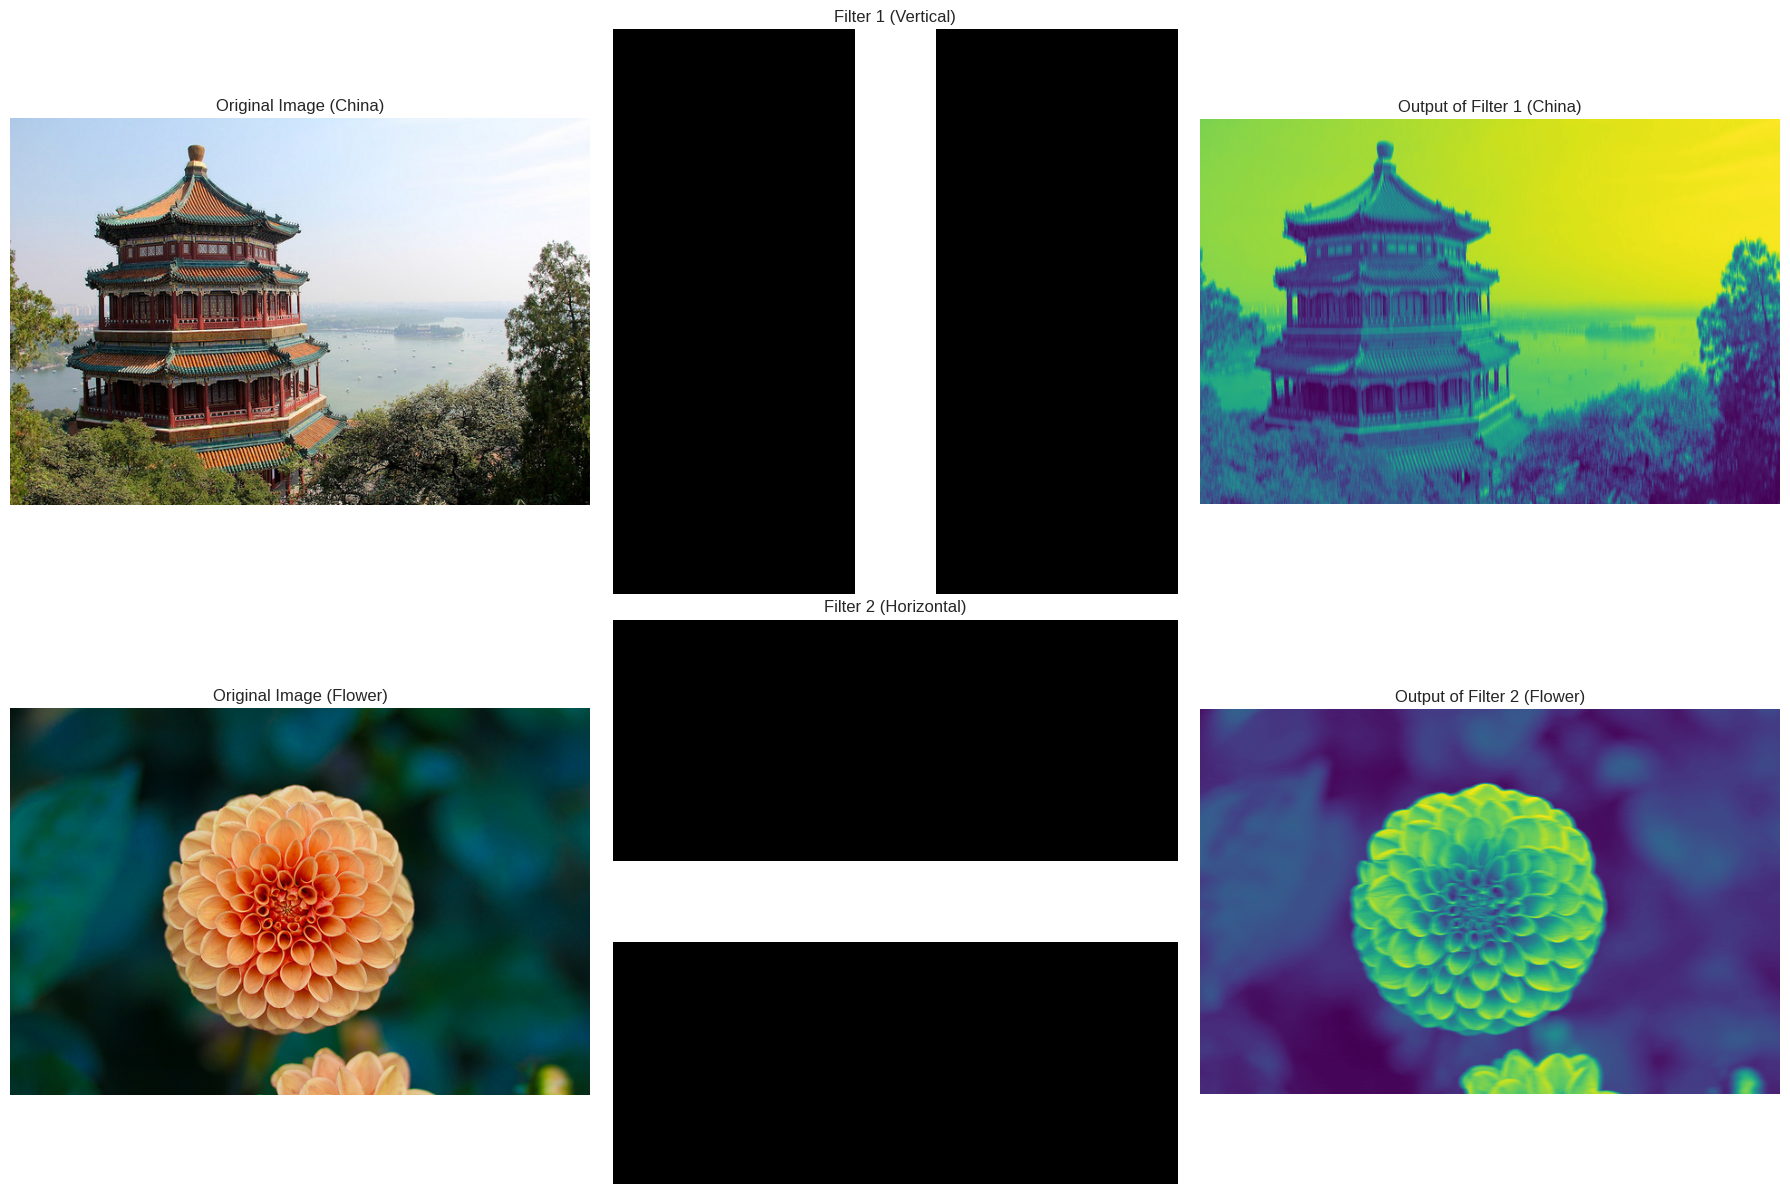

In [ ]:
# 결과 시각화: 원본 이미지, 필터, 컨볼루션 결과
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# 원본 이미지 표시
axs[0, 0].imshow(images[0].permute(1, 2, 0).numpy())
axs[0, 0].set_title('Original Image (China)')
axs[0, 0].axis('off')

axs[1, 0].imshow(images[1].permute(1, 2, 0).numpy())
axs[1, 0].set_title('Original Image (Flower)')
axs[1, 0].axis('off')

# 필터 시각화 (첫 번째 채널만 시각화)
axs[0, 1].imshow(filters[0, 0].numpy(), cmap='gray')
axs[0, 1].set_title('Filter 1 (Vertical)')
axs[0, 1].axis('off')

axs[1, 1].imshow(filters[1, 0].numpy(), cmap='gray')
axs[1, 1].set_title('Filter 2 (Horizontal)')
axs[1, 1].axis('off')

# 컨볼루션 결과 시각화 (첫 번째 배치, 첫 번째 필터 및 두 번째 필터)
axs[0, 2].imshow(output[0, 0].detach().numpy(), cmap='viridis')
axs[0, 2].set_title('Output of Filter 1 (China)')
axs[0, 2].axis('off')

axs[1, 2].imshow(output[1, 1].detach().numpy(), cmap='viridis')
axs[1, 2].set_title('Output of Filter 2 (Flower)')
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

1. 원본 이미지 표시

    - 첫 번째 행의 첫 번째 열에 중국 이미지를 시각화.
    - 두 번째 행의 첫 번째 열에 꽃 이미지를 시각화.

2. 필터 시각화

    - 첫 번째 필터(수직선 감지)와 두 번째 필터(수평선 감지)를 시각화.
    - 각 필터의 첫 번째 채널만을 시각화하여 이해를 돕습니다.

3. 컨볼루션 결과 시각화
    - 첫 번째 배치의 첫 번째 필터(수직선 감지) 적용 결과 시각화.
    - 두 번째 배치의 두 번째 필터(수평선 감지) 적용 결과 시각화.

4. 결과 해석
    - 수직선 감지 필터 적용 결과
        - 이미지 내 수직선의 윤곽선이 강조됩니다.
    - 수평선 감지 필터 적용 결과:
        - 이미지 내 수평선의 윤곽선이 강조됩니다.

> 참고

    - detach()를 사용하여 그래디언트 추적을 중단하고, .numpy()로 NumPy 배열로 변환하여 시각화합니다.

## 3. 패딩(Padding)과 스트라이드(Stride)

- 필터(커널) 사이즈과 함께 입력 이미지와 출력 이미지의 사이즈를 결정하기 위해 사용
- 사용자가 결정할 수 있음


### 3.1 패딩(Padding)

- 패딩은 입력 이미지의 가장자리에 특정 값(주로 0)을 추가하여, 입력 이미지의 크기를 인위적으로 확장하는 기법입니다.

- 목적

    - 출력 크기 조절
        - 패딩을 통해 출력 크기를 조절하여 입력 이미지의 공간 정보를 보존하거나 원하는 크기를 얻을 수 있습니다.
    - 가장자리 픽셀의 정보 손실 방지
        - 패딩을 사용하지 않으면 필터가 이미지의 가장자리에서 충분히 작동하지 못할 수 있습니다.
        - 패딩을 통해 가장자리 픽셀도 필터에 의해 처리되도록 합니다.

<img src="https://miro.medium.com/max/395/1*1okwhewf5KCtIPaFib4XaA.gif" width="300">

- 출력 데이터의 크기 계산

  $\quad (n+2p-f+1) \times (n+2p-f+1)$

    - n: 입력 이미지 크기
    - 𝑝: 패딩 크기
    - 𝑓: 필터 크기

  - 위 그림에서, 입력 이미지 크기($n$)는 5, 필터 크기($f$)는 3, 패딩 값($p$)은 1이므로 출력 데이터의 크기는 ($5 + 2\times 1 - 3 + 1) * (5 + 2\times 1 - 3 + 1)= 25$

  - 위와 같은 패딩은 'same' 패딩으로도 알려져 있으며, 입력과 출력의 크기를 동일하게 유지합니다.

- `valid`
  - 패딩을 사용하지 않음 (padding=0).
  - `padding=0`은 0으로 채워진 테두리가 아니라 패딩을 주지 않는다는 의미합니다.
  - 입력 이미지에서 필터가 적용되는 영역만 계산합니다. 즉, 출력 크기가 줄어듭니다.

- `same`
  - 입력 이미지의 크기를 유지하기 위해 패딩을 적용합니다.
  - 패딩 값은 필터 크기에 따라 결정됩니다.
  - 만약, 필터(커널)의 크기가 $k$ 이면, 패딩의 크기는 $p = \frac{k-1}{2}$ (단, stride=1)

### 3.2 스트라이드(Stride)

- 스트라이드는 필터가 입력 이미지 위를 이동하는 간격을 의미합니다.

- 특징

    - 스트라이드 크기
        - 기본적으로 스트라이드가 1일 경우 필터는 한 픽셀씩 이동하지만, 스트라이드를 2로 설정하면, 필터는 두 픽셀씩 건너뛰며 이동합니다.
    - 출력 크기 영향
        - 스트라이드가 커질수록 출력 특징 맵의 크기가 줄어듭니다.
        - 이는 계산량을 줄이고, 모델의 파라미터 수를 감소시키는 효과가 있습니다.
    - 정보 손실
        - 스트라이드를 크게 설정하면, 세밀한 정보는 손실될 수 있습니다. 따라서, 스트라이드 크기는 적절히 조절해야 합니다.
    - 아래 예제의 스트라이드는 2

    <img src="https://miro.medium.com/max/294/1*BMngs93_rm2_BpJFH2mS0Q.gif">

    - 예시

        - 스트라이드=1일 때, 필터가 한 픽셀씩 이동하여, 최대한 많은 정보를 추출합니다.

        - 스트라이드=2일 떄, 필터가 두 픽셀씩 이동하여, 출력 크기를 절반으로 줄이고, 계산량을 줄입니다.

### 3.3 출력 데이터의 크기

  $\qquad OH = \frac{H + 2P - FH}{S} + 1 $
  
  $\qquad OW = \frac{W + 2P - FW}{S} + 1 $

- $(H, W)$: 입력 이미지의 높이와 너비
- $(FH, FW)$: 필터의 높이와 너비
- $P, S$: 패딩, 스트라이드
- $(OH, OW)$: 출력 크기

- 위 식의 값에서 $\frac{H + 2P - FH}{S}$ 또는 $\frac{W + 2P - FW}{S}$가 정수로 나누어 떨어지는 값이어야 함
- 정수로 나누어 떨어지지 않으면, 패딩, 스트라이드 값을 조정하여 정수로 나누어 떨어지게 해야함
  
  

In [ ]:
# TensorFlow 컨볼루션과 풀링
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Dense

# 꽃 이미지 로드 및 배치 차원 추가
flower_tf = np.expand_dims(flower, axis=0)  # (1, 427, 640, 3)
print(flower_tf.shape)  # (1, 427, 640, 3)

# 컨볼루션 레이어 정의
conv_tf = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')

# 컨볼루션 연산 수행
output_tf = conv_tf(flower_tf)
print(output_tf.shape)  # (1, 427, 640, 32)

(1, 427, 640, 3)
(1, 427, 640, 32)


1. 이미지 로드 및 배치 차원 추가

    - np.expand_dims(flower, axis=0): 꽃 이미지에 배치 차원을 추가하여 (1, H, W, C) 형태로 변환.

2. 컨볼루션 레이어 정의

    - Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'): 3x3 필터를 사용하여 32개의 특징 맵을 생성하는 컨볼루션 레이어 정의.

    - 매개변수
        - filters=32: 출력 채널 수.
        - kernel_size=3: 필터 크기.
        - strides=1: 필터 이동 간격.
        - padding='same': 입력과 출력의 크기를 동일하게 유지.
        - activation='relu': ReLU 활성화 함수 적용.

3. 컨볼루션 연산 수행
    - output_tf = conv_tf(flower_tf): 꽃 이미지에 컨볼루션 연산을 적용하여 출력 특징 맵 생성.

> 참고

    - TensorFlow의 Conv2D 레이어는 입력 형태가 (batch_size, height, width, channels)입니다.
    - 활성화 함수는 레이어 정의 시 직접 적용됩니다.


In [ ]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# 이미지 예시 - 이미지 데이터
input_image = torch.randn(1, 3, 224, 224) # batch size=1, channel=3, 224x224 image

# PyTorch 컨볼루션 레이어
conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)

# 활성화 함수 적용 (ReLU)
output = F.relu(conv(input_image))
print(output.shape)

torch.Size([1, 16, 224, 224])


1. torch.randn(1, 3, 224, 224)

    - 샘플로 사용할 랜덤 이미지 데이터를 생성합니다. 여기서 배치 크기는 1, 채널 수는 3(RGB 이미지), 이미지 크기는 224x224입니다.

2. nn.Conv2d()

    - PyTorch에서 2D 컨볼루션 레이어를 정의하는 함수입니다.

        - in_channels=3: 입력 이미지의 채널 수를 지정합니다 (RGB 이미지의 경우 3).
        - out_channels=16: 16개의 필터(출력 채널)를 생성합니다.
        - kernel_size=3: 3x3 크기의 필터를 사용합니다.
        - stride=1: 필터를 한 픽셀씩 이동시킵니다.
        - padding=1: 3x3 필터에 대해 입력 크기를 유지하기 위한 'same' 패딩을 구현합니다.

3. F.relu()

    - PyTorch에서 ReLU 활성화 함수를 적용합니다. ReLU는 각 픽셀 값이 0보다 작을 경우 0으로, 0보다 크면 그 값을 그대로 반환합니다.

4. output.shape

    - 컨볼루션과 활성화 함수가 적용된 후의 출력 이미지의 크기를 출력합니다. 'same' 패딩을 사용했기 때문에 입력 이미지와 출력 이미지의 크기는 동일하게 유지됩니다.



## 4. 풀링(Pooling)

- 풀링은 컨볼루션 신경망에서 공간 차원을 축소하여 연산량을 줄이고, 모델의 과적합을 방지하며, 특징 맵의 중요한 정보를 추출하는 데 사용됩니다.

### 4.1 맥스 풀링(Max Pooling)

- 정의

    - 주어진 필터 크기 내에서 가장 큰 값을 추출하여 특징 맵의 크기를 줄이고, 모델의 파라미터 수와 연산 복잡성을 감소시키는 연산입니다.

- 특징

    - 모델이 물체의 주요한 특징을 학습할 수 있도록 해주며, 공간 불변성(spatial invariance)을 제공하여, 객체의 위치 변화에 강인한 특징을 추출합니다.
    - 노이즈를 제거하고, 가장 두드러진 특징을 강조하는 데 효과적입니다.
    - 일반적으로 stride=2, kernel_size=2로 설정하여 특징 맵의 크기를 절반으로 줄입니다.
    - 예를 들어, 아래의 그림에서 초록색 사각형 안에 있는 2와 8의 위치를 바꾼다해도 맥스 풀링 연산은 8을 추출

  <img src="https://cs231n.github.io/assets/cnn/maxpool.jpeg" width="600">

In [ ]:
# TensorFlow
from tensorflow.keras.layers import MaxPool2D

In [ ]:
# TensorFlow

# 꽃 이미지 로드
print(flower.shape)

# 배치 차원 추가
flower_tf = np.expand_dims(flower, axis=0)  # (1, 427, 640, 3)
print(flower_tf.shape)  # (1, 427, 640, 3)

# 컨볼루션 연산 수행
output_tf = conv_tf(flower_tf)
print(output_tf.shape)  # (1, 427, 640, 32)

# 맥스 풀링 적용
max_pool_tf = MaxPool2D(pool_size=2, strides=2, padding='valid')
output_max_pool_tf = max_pool_tf(output_tf)
print(output_max_pool_tf.shape)  # (1, 213, 320, 32)

(427, 640, 3)
(1, 427, 640, 3)
(1, 427, 640, 32)
(1, 213, 320, 32)


1. 맥스 풀링 적용
    - MaxPool2D(pool_size=2, strides=2, padding='valid'): 2x2 풀링 필터를 사용하여 특징 맵의 크기를 절반으로 줄임.
    - padding='valid': 패딩을 사용하지 않음.

2. 출력 크기 확인
    - 컨볼루션 연산 후 출력 크기: (1, 427, 640, 32)
    - 맥스 풀링 후 출력 크기: (1, 213, 320, 32)

torch.Size([1, 32, 112, 112])


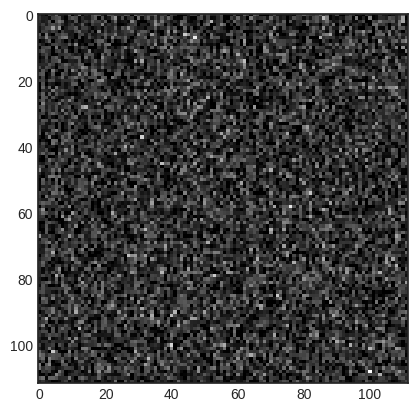

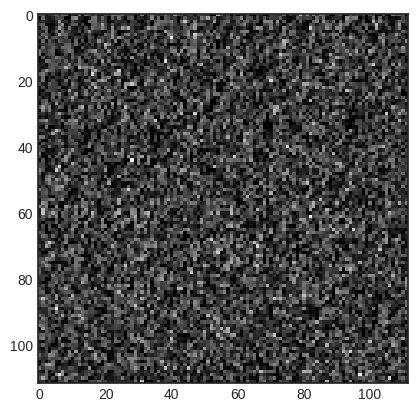

In [ ]:
# 이미지 데이터 예시 (실제 데이터로 대체 필요)
flower = torch.randn(1, 3, 224, 224)  # 배치 크기 1, 채널 3, 224x224 크기의 이미지

# PyTorch 컨볼루션 레이어
conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # 'same' 패딩 구현

# 맥스 풀링 레이어 정의 (kernel_size=2, stride=2)
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

# 컨볼루션 연산 수행 후 맥스 풀링 적용
output = F.relu(conv(flower))
output = max_pool(output)

print(output.shape)

# 시각화를 위해 특정 채널에 대한 결과를 이미지로 출력
plt.imshow(output[0, 4, :, :].detach().cpu().numpy(), cmap='gray')  # 5번째 채널 이미지 출력
plt.show()

plt.imshow(output[0, 8, :, :].detach().cpu().numpy(), cmap='gray')  # 9번째 채널 이미지 출력
plt.show()


1. torch.randn(1, 3, 224, 224)

    - 가상의 이미지를 생성합니다. 배치 크기 1, 채널 3 (RGB 이미지), 이미지 크기 224x224입니다.

2. nn.Conv2d()

    - 3x3 필터를 사용하여 32개의 출력 채널을 생성하는 컨볼루션 레이어입니다. padding=1을 사용해 입력 이미지의 크기를 유지합니다.

3. F.relu()
    - ReLU 활성화 함수를 적용하여 음수 값을 0으로 변환하고, 양수 값은 그대로 유지합니다.

4. nn.MaxPool2d(kernel_size=2, stride=2)
    - 2x2 크기의 필터로 맥스 풀링을 수행하고, 스트라이드를 2로 설정하여 출력 크기를 절반으로 줄입니다.

5. output.shape

    - 출력 텐서의 크기를 출력합니다. 맥스 풀링을 통해 입력 이미지 크기가 절반으로 줄어듭니다.

6. 시각화

    - 출력 텐서의 특정 채널에 대한 이미지를 matplotlib를 사용해 시각화합니다. 여기서는 5번째와 9번째 채널을 그레이스케일로 출력합니다.

### 4.2 평균 풀링(Avg Pooling)

- 정의

    - 필터 영역 내의 값들의 평균을 계산하여 출력하는 연산입니다.

        - 맥스풀링과 마찬가지로 stride=2, kernel_size=2 를 통해 특징 맵의 사이즈를 줄이는 역할

- 특징

    - 전체적인 정보의 흐름을 유지하지만, 가장 두드러진 특징을 강조하지는 않습니다.
    - 최근에는 맥스 풀링에 비해 덜 사용되며, 주로 특별한 목적이나 실험적인 모델에서 사용됩니다.


  <img src="https://www.researchgate.net/profile/Juan_Pedro_Dominguez-Morales/publication/329885401/figure/fig21/AS:707709083062277@1545742402308/Average-pooling-example.png" width="600">


In [ ]:
# TensorFlow
from tensorflow.keras.layers import AvgPool2D

In [ ]:
# TensorFlow
print(flower.shape)

output = Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(flower)
output = AvgPool2D(pool_size = 2)(output)
print(output.shape)

torch.Size([1, 3, 224, 224])
(1, 1, 112, 32)


In [ ]:
# PyTorch

# 평균 풀링 레이어 정의
avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)

# 컨볼루션 연산 수행 후 평균 풀링 적용
output_avg = F.relu(conv(images))
output_avg = avg_pool(output_avg)

print(output_avg.shape)  # torch.Size([2, 2, 210, 317])

torch.Size([2, 32, 213, 320])


1. 평균 풀링 레이어 정의
    - nn.AvgPool2d(kernel_size=2, stride=2): 2x2 풀링 필터를 사용하여 특징 맵의 크기를 절반으로 줄임.

2. 컨볼루션 연산 및 풀링 적용
    - F.relu(conv(images)): 컨볼루션 연산 후 ReLU 활성화 함수 적용.
    - avg_pool(output_avg): 평균 풀링을 통해 출력 크기를 절반으로 줄임.

3. 출력 크기 확인
    - 입력 크기: (2, 3, 427, 640)
    - 필터 크기: 7x7
    - 컨볼루션 후 크기: (2, 2, 421, 634)
    - 평균 풀링 후 크기: (2, 2, 210, 317)

4. 결과 시각화
    - 첫 번째 배치의 첫 번째 필터 적용 결과 시각화.
    - 두 번째 배치의 두 번째 필터 적용 결과 시각화.
    - cmap='gray': 그레이스케일로 시각화.

> 참고

    - detach()를 사용하여 그래디언트 추적을 중단하고, .cpu().numpy()로 NumPy 배열로 변환하여 시각화.
    - 각 채널별로 특징 맵을 시각화하여 필터의 효과를 확인.

### 4.3 전역 평균 풀링(Global Avg Pooling)

- 정의
    - 각 채널별로 특성 맵의 공간 차원(H, W)에 대한 평균을 계산하여 (C, 1, 1) 형태의 출력을 얻는 연산입니다.

- 특징:
    - 완전 연결 계층을 대체하여 모델의 파라미터 수를 줄이고, 과적합을 방지합니다.
    - 주로 분류 문제의 마지막 단계에서 사용되며, 특징 맵을 간결하게 요약합니다.
    - 각 채널별로 전체 공간 정보를 하나의 값으로 요약하여, 모델의 효율성을 높입니다.

    <img src="https://www.researchgate.net/publication/355537491/figure/fig3/AS:1082971696177153@1635211981186/Comparison-of-the-fully-connected-layer-and-global-average-pooling-layer.png" width="600" alt="Global Average Pooling Example">

In [ ]:
# TensorFlow
from tensorflow.keras.layers import GlobalAvgPool2D

In [ ]:
# TensorFlow
print(flower.shape)

output_tf = Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(flower)

# TensorFlow의 전역 평균 풀링 적용 예제
output_global_avg_tf = GlobalAvgPool2D()(output_tf)
print(output_global_avg_tf.shape)  # (1, 32)

torch.Size([1, 3, 224, 224])
(1, 32)


In [ ]:
# PyTorch

# 전역 평균 풀링 레이어 정의
global_avg_pool = nn.AdaptiveAvgPool2d(1)  # (배치_size, channels, 1, 1)

# 컨볼루션 연산 수행 후 전역 평균 풀링 적용
output_global_avg = F.relu(conv(images))
output_global_avg = global_avg_pool(output_global_avg)

print("Global Average Pooling Output Shape:", output_global_avg.shape)  # torch.Size([2, 2, 1, 1])


Global Average Pooling Output Shape: torch.Size([2, 32, 1, 1])


1. 전역 평균 풀링 레이어 정의

    - nn.AdaptiveAvgPool2d(1): 각 채널별로 전체 공간에 대한 평균을 계산하여 (batch_size, channels, 1, 1) 형태의 출력을 생성.

2. 컨볼루션 연산 및 풀링 적용
    - F.relu(conv(images)): 컨볼루션 연산 후 ReLU 활성화 함수 적용.
    - global_avg_pool(output_global_avg): 전역 평균 풀링을 통해 각 채널별 평균 값을 추출.

3. 출력 크기 확인
    - 출력 크기는 (2, 2, 1, 1)로, 각 배치와 채널에 대해 하나의 평균 값이 생성됩니다.

> 참고

    - 전역 평균 풀링은 모델의 파라미터 수를 줄이고, 과적합을 방지하는 데 유용합니다.
    - 주로 CNN의 마지막 단계에서 완전 연결 계층 대신 사용됩니다.

## 5. 완전 연결 계층(Fully-Connected Layer)

- 정의
    - 완전 연결 계층은 입력 텐서를 1차원으로 펼쳐(Flatten) 각 입력 뉴런을 모든 출력 뉴런에 연결하는 신경망 계층입니다.

- 특징
    - 모든 입력과 출력 노드가 연결되어 있어 데이터의 공간 정보를 잃게 되지만, 전체적인 패턴이나 클래스 분류에는 유용합니다.
    - CNN에서 추출된 특징을 바탕으로 최종 분류나 회귀를 수행하는 데 사용됩니다.

- 활성화 함수
    - 출력 뉴런의 수와 활성화 함수는 문제 유형에 따라 선택합니다.
        - 이진 분류
            - 출력 뉴런 수 1개, Sigmoid 활성화 함수 사용
        - 다중 클래스 분류
            - 출력 뉴런 수 = 클래스 개수, Softmax 활성화 함수 사용

In [ ]:
# TensorFlow
from tensorflow.keras.layers import Dense

# 완전 연결 계층 적용
fc_tf = Dense(units=64, activation='relu')
output_fc_tf = fc_tf(output_global_avg_tf)
print(output_fc_tf.shape)  # (1, 64)

(1, 64)


### PyTorch로 변환된 코드

In [ ]:
import torch
import torch.nn as nn

# PyTorch의 Linear 레이어 사용
fc = nn.Linear(in_features=128, out_features=64)  # in_features는 입력 차원, out_features는 출력 차원

# 활성화 함수 정의
activation = nn.ReLU()  # ReLU 활성화 함수

# 샘플 입력 (예: Flatten 후의 128차원 입력)
input_tensor = torch.randn(1, 128)  # 배치 크기 1, 입력 크기 128

# 완전 연결 계층 및 활성화 함수 적용
output = activation(fc(input_tensor))

print("Output shape:", output.shape)

Output shape: torch.Size([1, 64])


1. nn.Linear(): PyTorch에서 완전 연결(밀집) 계층을 정의하는 함수입니다. in_features는 입력 뉴런의 개수, out_features는 출력 뉴런의 개수를 의미합니다.

- 여기서는 입력 크기가 128, 출력 크기가 64로 설정되었습니다. 입력 크기는 데이터를 네트워크에 전달할 때 결정되며, 출력 크기는 사용자가 원하는 결과 크기 (예: 클래스 개수)입니다.

2. nn.ReLU(): ReLU 활성화 함수입니다. 각 뉴런의 출력 값이 0보다 크면 그대로 출력하고, 0보다 작으면 0을 반환하는 비선형 활성화 함수입니다.

3. torch.randn(1, 128): 랜덤한 입력 데이터를 생성합니다. 배치 크기는 1, 입력 크기는 128입니다.

4. output = activation(fc(input_tensor)): 완전 연결 계층을 통과한 후 활성화 함수를 적용합니다. 이 과정에서 입력 데이터가 완전 연결 계층을 통해 64개의 출력 값으로 변환되고, ReLU 활성화 함수가 적용됩니다.

## 유효 수용 영역(ERF, Effective Receptive Field)

- 정의
    - 신경망의 특정 뉴런이 입력 이미지에서 실제로 영향을 받는 영역을 의미합니다.

- 수용 영역의 중요성
    - 수용 영역이 커질수록 더 넓은 범위의 정보를 통합하여 복잡한 특징을 학습할 수 있습니다.
    - 깊은 신경망에서는 여러 계층을 거치면서 수용 영역이 점차 넓어집니다.

    <img src="https://wiki.math.uwaterloo.ca/statwiki/images/8/8c/understanding_ERF_fig0.png" width="600" alt="Effective Receptive Field Example">



### 수용 영역의 특징

- 중앙부의 중요성:

    - 수용 영역 내에서 중앙부의 픽셀이 더 큰 영향을 미치며, 주변부로 갈수록 영향이 감소합니다.

- 가우시안 분포
    - 실제로 신경망의 수용 영역은 완벽한 사각형이 아니라, 중심부가 강조되는 가우시안 분포 형태를 보입니다.
    - 이는 네트워크의 가중치가 중심부에 집중되고, 주변부에서는 작은 값이 할당되기 때문입니다.

### 시각화

- 수용 영역의 크기와 형태를 시각화하여 이해를 돕습니다.

- 수용 영역이 어떻게 계층을 거치며 확장되는지, 그리고 어떤 영역이 뉴런에 더 큰 영향을 미치는지 파악할 수 있습니다.

    <img src="https://www.researchgate.net/publication/316950618/figure/fig4/AS:495826810007552@1495225731123/The-receptive-field-of-each-convolution-layer-with-a-3-3-kernel-The-green-area-marks.png" width="600" alt="Receptive Field Visualization">

<img src="https://www.researchgate.net/publication/351927650/figure/fig2/AS:1028350436974595@1622189258915/Visualizations-of-convolutional-feature-maps-The-feature-maps-are-extracted-from.png">